Some Python code to read in, plot and integrate ICPMS data for Hg analysis. Requires specifying start/stop times for the peaks (doesn't find the peaks on its own)

In [5]:
# prep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# setup some functions to use later
def basearea(start, stop, df):
    x=stop-start
    y=(df[start]+df[stop])/2.
    return x*y

def peakarea(start, stop, df, basearea):
    return df[start:stop].sum()-basearea

def baseline(start, stop, df):
    slope=(df[stop]-df[start])/(stop-start)
    linepoints=np.arange(0,stop-start)
    return linepoints*slope+df[start]

Choose your ICP files

In [13]:
from google.colab import files
uploaded = files.upload() # this will place versions on your Google Drive
filenames=list(uploaded.keys())

Saving N1.E.3.TXT to N1.E.3 (1).TXT


Plot the chromatograms to see if you like the start/stop times

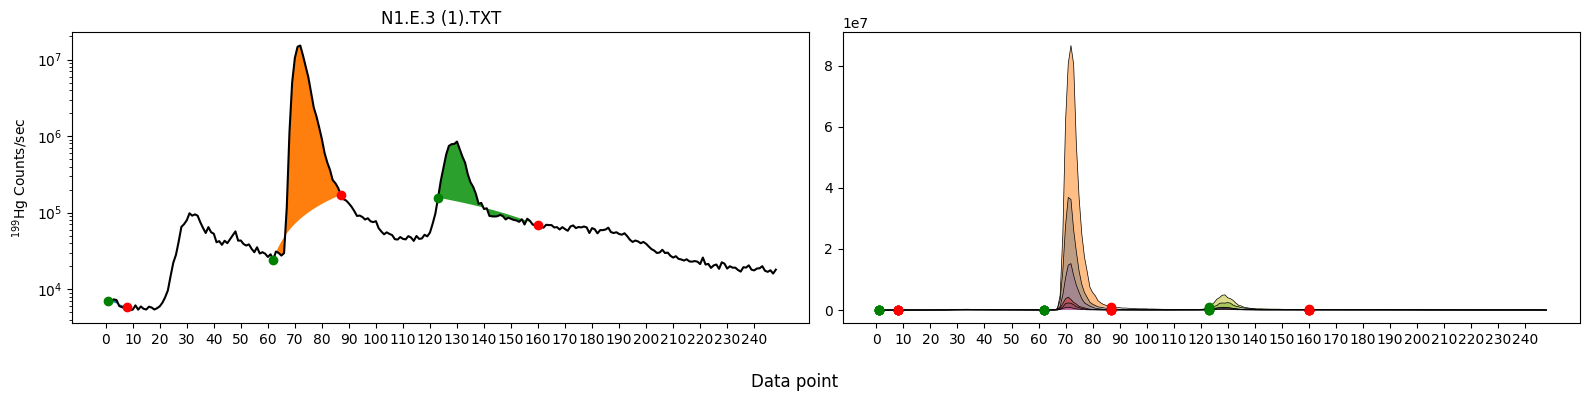

In [14]:
starts=np.array([1,62,123]) #index number, not time, will show up as green dots
stops=np.array([8,87,160]) #index number, not time, will show up as red dots

figdim=(16,4*len(filenames))
titles=['$^{198}$Hg','$^{199}$Hg','$^{200}$Hg','$^{201}$Hg','$^{202}$Hg','$^{204}$Hg']

fig, axs = plt.subplots(len(filenames),2, sharex=True, figsize=figdim)

if len(filenames)>1:
  for i in range(0,len(filenames)):
    data=pd.read_csv(filenames[i],skiprows=5, sep='\t') #change sep='\t' for tab-delimited or sep=',' for comma-delimited.
    axs[i,0].plot(data.iloc[:,2],'k') # column 2 is the 199 counts.
    axs[i,0].set_yscale('log')
    for species in range(0,3):
        axs[i,0].plot(starts[species],data.iloc[starts[species],2],'go')
        axs[i,0].plot(stops[species],data.iloc[stops[species],2],'ro')
        axs[i,0].fill_between(range(starts[species],stops[species]), data.iloc[starts[species]:stops[species],2],
                       baseline(starts[species],stops[species],data.iloc[:,2]) )
    for isotope in range(1,7):
      axs[i,1].plot(data.iloc[:,isotope],'k')
      for species in range(0,3):
       axs[i,1].plot(starts[species],data.iloc[starts[species],isotope],'go')
       axs[i,1].plot(stops[species],data.iloc[stops[species],isotope],'ro')
       axs[i,1].fill_between(range(starts[species],stops[species]), data.iloc[starts[species]:stops[species],isotope],
                       baseline(starts[species],stops[species],data.iloc[:,isotope]) )
        #axs[i,1].set_title(titles[isotope])

  for i in range(0,len(filenames)):
    axs[i,0].set_title(filenames[i])

  fig.supylabel('$^{199}$Hg Counts/sec')

else:
  data=pd.read_csv(filenames[0],skiprows=5, sep='\t')
  axs[0].plot(data.iloc[:,2],'k') # column 2 is the 199 counts.
  axs[0].set_yscale('log')
  axs[0].set_ylabel('$^{199}$Hg Counts/sec')
  axs[0].set_title(filenames[0])
  plt.xticks(np.arange(0,len(data),10))
  for species in range(0,3):
    axs[0].plot(starts[species],data.iloc[starts[species],2],'go')
    axs[0].plot(stops[species],data.iloc[stops[species],2],'ro')
    axs[0].fill_between(range(starts[species],stops[species]), data.iloc[starts[species]:stops[species],2],
                       baseline(starts[species],stops[species],data.iloc[:,2]) )

  for isotope in range(1,7):
    axs[1].plot(data.iloc[:,isotope],'k', linewidth=0.5)
    for species in range(0,3):
      axs[1].plot(starts[species],data.iloc[starts[species],isotope],'go')
      axs[1].plot(stops[species],data.iloc[stops[species],isotope],'ro')
      axs[1].fill_between(range(starts[species],stops[species]), data.iloc[starts[species]:stops[species],isotope],
                       baseline(starts[species],stops[species],data.iloc[:,isotope]), alpha=0.5)




fig.supxlabel('Data point')
plt.tight_layout()
plt.show()

Crunch the numbers!

In [ ]:

results=pd.DataFrame([],columns=['File','Hg0_198','MMHg_198', 'Hg(II)_198',
                      'Hg0_199','MMHg_199', 'Hg(II)_199',
                      'Hg0_200','MMHg_200', 'Hg(II)_200',
                      'Hg0_201','MMHg_201', 'Hg(II)_201',
                      'Hg0_202','MMHg_202', 'Hg(II)_202',
                      'Hg0_204','MMHg_204', 'Hg(II)_204'])

results.File=filenames

for file in range(0,len(filenames)):
    data=pd.read_csv(filenames[file],skiprows=5, sep='\t')
    counts=data.iloc[:,1:7] #counts per second

    temp_result=np.array([])

    for isotope in range(0,len(counts.columns)):
        peaks=np.zeros(3)
        for species in range(0,3):
            base=basearea(starts[species], stops[species],counts.iloc[:,isotope])
            peak=peakarea(starts[species], stops[species],counts.iloc[:,isotope], base)
            peaks[species]=peak

        temp_result=np.concatenate((temp_result,peaks))

    results.iloc[file,1:]=temp_result

results.head()

,File,Hg0_198,MMHg_198,Hg(II)_198,Hg0_199,MMHg_199,Hg(II)_199,Hg0_200,MMHg_200,Hg(II)_200,Hg0_201,MMHg_201,Hg(II)_201,Hg0_202,MMHg_202,Hg(II)_202,Hg0_204,MMHg_204,Hg(II)_204
0,dx_94_2 (1).TXT,783.25,78826908.992188,3287239.787598,57.700684,54658281.042969,5114274.391602,-47.349609,38730866.513184,14845679.640625,-1779.300171,19188056.47876,3524414.959229,3016.150391,41543236.035645,7868244.707031,49.449768,9566532.945068,1482083.723633


Output the data

In [ ]:
from google.colab import files

results.to_csv('icp_results_gf006_dup.csv')
files.download('icp_results_gf006_dup.csv') # can add path here too if you like


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>